In [10]:

import numpy as np
from clawpack import riemann
from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn
import logging
import numpy as np
from clawpack import riemann

def setup(use_petsc=0,kernel_language='Fortran',outdir='./_output',solver_type='classic'):
    logger = logging.getLogger('pyclaw')
    logger.setLevel(logging.CRITICAL)
    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Python': 
        riemann_solver = riemann.burgers_1D_py.burgers_1D
    elif kernel_language == 'Fortran':
        riemann_solver = riemann.burgers_1D

    if solver_type=='sharpclaw':
        solver = pyclaw.SharpClawSolver1D(riemann_solver)
    else:
        solver = pyclaw.ClawSolver1D(riemann_solver)
        solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = kernel_language
        
    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic

    xlower = 0
    xupper = 2*np.pi
    mx = 256
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    
    domain = pyclaw.Domain(x)
    num_eqn = 1
    state = pyclaw.State(domain,num_eqn)

    xc = state.grid.x.centers
    beta = 1. + 0.25 * (2*np.random.rand() - 1)
    alpha = 0.25 * (2*np.random.rand() - 1)
    # print(beta, alpha)
    state.q[0,:] =  beta * np.sin(xc) + alpha
    state.problem_data['efix']=True

    claw = pyclaw.Controller()
    claw.tfinal = 0.005*20
    claw.num_output_times = 20
    claw.output_format = None
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.setplot = setplot
    claw.keep_copy = True

    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    # Figure for q[0]
    plotfigure = plotdata.new_plotfigure(name='q[0]', figno=0)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = [-1., 2.]
    plotaxes.title = 'q[0]'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    
    return plotdata


# np.random.seed(51349) # eval
np.random.seed(0) # train
# np.random.seed(123456789) # test
from clawpack.pyclaw.util import run_app_from_main
sol = []

sol = []
count = 0
while count < 200:
    # Access the specific sol[j]
    claw = setup()
    output = claw.run()

    # Check if any frame has NaN in q
    has_nan = any(np.isnan(frame.q).any() for frame in claw.frames)

    # If no NaN is found, add to the valid list and increase the count
    if not has_nan:
        sol.append([claw.frames[i].q for i in range(len(claw.frames))])
        count += 1
    else:
        print("Has NaN, run another test...")


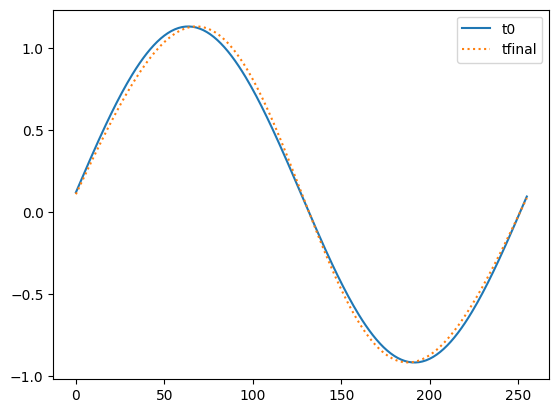

In [11]:
import matplotlib.pyplot as plt
# Cell 1 stores each trajectory as a list of q arrays (not Solution/Frame objects).
# Each q has shape (num_eqn, mx) for Burgers: (1, mx).
plt.plot(sol[0][0][0, :], label='t0')
plt.plot(sol[0][-1][0, :], ':', label='tfinal')
plt.legend()

In [13]:
# Inspect a single saved frame (q array) from the first trajectory.
q1 = sol[0][1]  # q at output time index 1
print('q1 type:', type(q1))
print('q1 shape:', np.asarray(q1).shape)
print('q1 stats: min/max/mean =', float(np.min(q1)), float(np.max(q1)), float(np.mean(q1)))

q1 type: <class 'numpy.ndarray'>
q1 shape: (1, 256)
q1 stats: min/max/mean = -0.9167349328330618 1.1319242992054814 0.10759468318620974


In [14]:
# Stack into a single array: (n_traj, n_frames, num_eqn, mx)
Data = np.stack([np.stack(traj, axis=0) for traj in sol], axis=0)
print('Data shape:', Data.shape)

Data shape: (200, 21, 1, 256)


In [15]:
import os
os.makedirs('Data', exist_ok=True)
Data_out = np.swapaxes(Data, 2, 3)  # (n_traj, n_frames, mx, num_eqn)
np.save('Data/trainData_Burgers_256.npy', Data_out)
print('Saved:', 'Data/trainData_Burgers_256.npy', 'with shape', Data_out.shape)

Saved: Data/trainData_Burgers_256.npy with shape (200, 21, 256, 1)


In [16]:
# Confirm shapes match training code expectation: (S, T, N, C)
print('Data (raw) shape:', Data.shape)
print('Data (saved) shape:', np.swapaxes(Data, 2, 3).shape)

Data (raw) shape: (200, 21, 1, 256)
Data (saved) shape: (200, 21, 256, 1)


In [17]:
# Example (beta, alpha) pairs observed (for reference)
low_beta_alpha = (1.0560860128265581, 0.19971456272826715)
high_beta_alpha = (1.1881292794712532, -0.009834072484913248)
print('Low (beta, alpha):', low_beta_alpha)
print('High (beta, alpha):', high_beta_alpha)

Low (beta, alpha): (1.0560860128265581, 0.19971456272826715)
High (beta, alpha): (1.1881292794712532, -0.009834072484913248)


In [18]:
# --- Helpers to generate val/test datasets (without re-running the big train loop) ---
import os
import numpy as np
from clawpack import riemann
import logging

def setup_param(
    mx=256,
    tfinal=0.005*20,
    num_output_times=20,
    beta=None,
    alpha=None,
    kernel_language='Fortran',
    solver_type='classic',
    outdir='./_output',
    use_petsc=0,
    seed=None,
    ):
    logger = logging.getLogger('pyclaw')
    logger.setLevel(logging.CRITICAL)
    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if seed is not None:
        np.random.seed(int(seed))

    if kernel_language == 'Python':
        riemann_solver = riemann.burgers_1D_py.burgers_1D
    elif kernel_language == 'Fortran':
        riemann_solver = riemann.burgers_1D
    else:
        raise ValueError(f'Unknown kernel_language: {kernel_language!r}')

    if solver_type == 'sharpclaw':
        solver = pyclaw.SharpClawSolver1D(riemann_solver)
    else:
        solver = pyclaw.ClawSolver1D(riemann_solver)
        solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = kernel_language

    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic

    xlower = 0
    xupper = 2*np.pi
    x = pyclaw.Dimension(xlower, xupper, mx, name='x')
    domain = pyclaw.Domain(x)

    state = pyclaw.State(domain, 1)
    xc = state.grid.x.centers

    if beta is None:
        beta = 1. + 0.25 * (2*np.random.rand() - 1)
    if alpha is None:
        alpha = 0.25 * (2*np.random.rand() - 1)

    state.q[0, :] = beta * np.sin(xc) + alpha
    state.problem_data['efix'] = True

    claw = pyclaw.Controller()
    claw.tfinal = tfinal
    claw.num_output_times = num_output_times
    claw.output_format = None
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.keep_copy = True

    return claw


def generate_trajectories(n_traj, setup_fn, *, require_finite=True):
    out = []
    count = 0
    while count < n_traj:
        claw = setup_fn()
        claw.run()
        frames = [claw.frames[i].q for i in range(len(claw.frames))]
        if (not require_finite) or all(np.isfinite(q).all() for q in frames):
            out.append(frames)
            count += 1
        else:
            print('Has NaN/Inf, retry...')
    return out


def save_dataset(sol_list, path):
    os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
    data = np.stack([np.stack(traj, axis=0) for traj in sol_list], axis=0)  # (S, T, C, N)
    data_out = np.swapaxes(data, 2, 3)  # (S, T, N, C)
    np.save(path, data_out)
    print('Saved', path, 'shape', data_out.shape)

In [19]:
# --- Validation set (different seed) ---
np.random.seed(51349)
sol_val = generate_trajectories(
    n_traj=50,
    setup_fn=lambda: setup_param(mx=256, tfinal=0.005*20, num_output_times=20),
    require_finite=True,
)
save_dataset(sol_val, 'Data/valData_Burgers_256.npy')

Saved Data/valData_Burgers_256.npy shape (50, 21, 256, 1)


In [20]:
# --- Test set: fixed (beta, alpha) "Low" and long rollout (601 frames) ---
beta_low, alpha_low = low_beta_alpha
claw_test = setup_param(mx=256, tfinal=0.005*600, num_output_times=600, beta=beta_low, alpha=alpha_low)
claw_test.run()
sol_test_low = [[claw_test.frames[i].q for i in range(len(claw_test.frames))]]
save_dataset(sol_test_low, 'Data/testData_Burgers_256_Low.npy')

Saved Data/testData_Burgers_256_Low.npy shape (1, 601, 256, 1)
